# Top Lane Laning Phase – Lane Outcome Model

Trains and inspects a simple model that predicts whether you will **end the lane ahead in CS** (`is_ahead_final`) based on early-game top lane snapshots.

1. Load the dataset of lane snapshots (`top_matches_summary.csv`).
2. Explore basic distributions and relationships.
3. Train two models:
   - Logistic Regression (interpretable coefficients).
   - Random Forest (non-linear, feature importances).
4. Visualize some results for intuition.


## 1. Setup & Data Loading

Adjust `DATA_PATH` for CSV file.


In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = Path("data/datasets/top_matches_summary_v1.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV not found at {DATA_PATH} – adjust the path if needed.")

datafile = pd.read_csv(DATA_PATH)
datafile.head()

,match_id,time_s,cs_self,cs_enemy,cs_diff,xp_self,xp_enemy,xp_diff,self_x,self_y,enemy_x,enemy_y,champ_distance,self_base_distance,cs_diff_final,is_ahead_final
0,NA1_5408967392,0.000,0,0,0,0,0,0,14103,14195,603,611,19151.372170,2618.517520,15,1
1,NA1_5408967392,60.014,0,0,0,0,0,0,3237,13735,1002,12128,2752.757527,12962.422382,15,1
2,NA1_5408967392,120.031,3,3,0,185,215,-30,2941,12582,2224,12125,850.257608,13498.896436,15,1
3,NA1_5408967392,180.037,10,11,-1,675,768,-93,3350,13155,1640,11484,2390.887074,12965.975667,15,1
4,NA1_5408967392,240.043,17,17,0,1288,1230,58,1778,11767,1242,10748,1151.371791,14838.583928,15,1


## 2. Quick EDA (Exploratory Data Analysis)

We'll look at:

- Distribution of `cs_diff`.
- Distribution of the target `is_ahead_final`.
- Relationship between `cs_diff` and `is_ahead_final`.


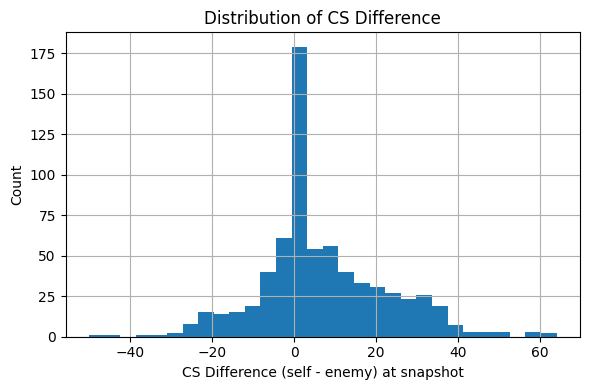

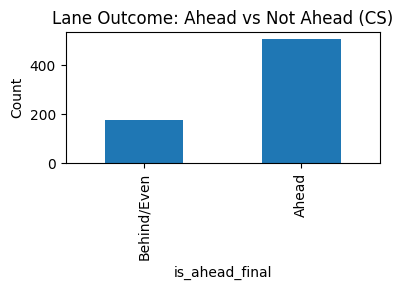

In [5]:
# Histogram of CS difference at snapshot time
plt.figure(figsize=(6, 4))
datafile['cs_diff'].hist(bins=30)
plt.xlabel('CS Difference (self - enemy) at snapshot')
plt.ylabel('Count')
plt.title('Distribution of CS Difference')
plt.tight_layout()
plt.show()

# Target distribution
plt.figure(figsize=(4, 3))
datafile['is_ahead_final'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0, 1], ['Behind/Even', 'Ahead'])
plt.ylabel('Count')
plt.title('Lane Outcome: Ahead vs Not Ahead (CS)')
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

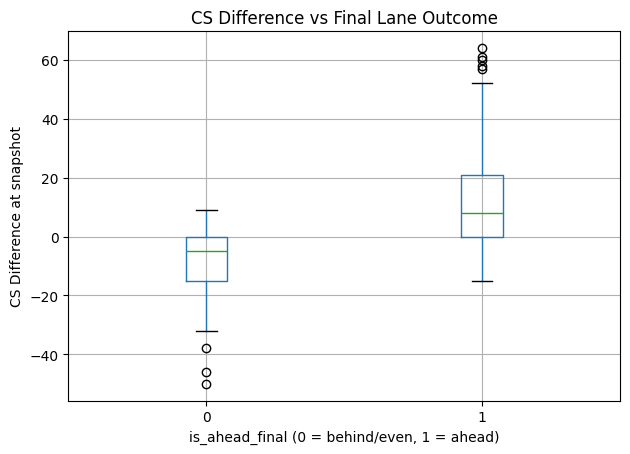

In [6]:
# Simple boxplot: cs_diff grouped by final lane outcome
plt.figure(figsize=(6, 4))
datafile.boxplot(column='cs_diff', by='is_ahead_final')
plt.suptitle('')
plt.xlabel('is_ahead_final (0 = behind/even, 1 = ahead)')
plt.ylabel('CS Difference at snapshot')
plt.title('CS Difference vs Final Lane Outcome')
plt.tight_layout()
plt.show()

## 3. Train/Test Split and Feature Selection

    (Did some research for feature selection)
- `cs_diff`: key economic factor.
- `xp_diff`: level advantage.
- `self_base_distance`: overextension / lane position.
- `champ_distance`: distance between champions (pressure / zone info).
- `time_s`: time in seconds since game start.

## Divide dataset for 75% Train set and 25% Test set




In [7]:
from sklearn.model_selection import train_test_split

feature_columns = [
    'cs_diff',
    'xp_diff',
    'self_base_distance',
    'champ_distance',
    'time_s',
]
target_column = 'is_ahead_final'

# Drop rows with missing values just in case
df_model = datafile.dropna(subset=feature_columns + [target_column])

X = df_model[feature_columns].values
y = df_model[target_column].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((515, 5), (172, 5))

## 4. Logistic Regression

We use a pipeline:

- `StandardScaler` – normalizes features.
- `LogisticRegression` – linear model with coefficients we can inspect.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

logit_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)

logit_pipeline.fit(X_train, y_train)

y_pred = logit_pipeline.predict(X_test)
y_proba = logit_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:\n")
print(classification_report(y_test, y_pred, digits=3))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
except Exception as error:
    print("ROC AUC calculation failed:", error)

# Inspect coefficients
clf = logit_pipeline.named_steps['clf']
coeff = clf.coef_[0]

print("\nLogistic Regression Coefficients:")
for name, c in zip(feature_columns, coeff):
    print(f"  {name:20s}: {c:+.3f}")

Logistic Regression Results:

              precision    recall  f1-score   support

           0      0.786     0.489     0.603        45
           1      0.840     0.953     0.893       127

    accuracy                          0.831       172
   macro avg      0.813     0.721     0.748       172
weighted avg      0.826     0.831     0.817       172

ROC AUC: 0.8768153980752406

Logistic Regression Coefficients:
  cs_diff             : +3.335
  xp_diff             : -0.591
  self_base_distance  : +0.192
  champ_distance      : +0.030
  time_s              : -0.327


### Visualizing the effect of CS difference

We can hold other features at their median values and vary `cs_diff` to see how it affects the model's predicted probability of ending lane ahead in CS.


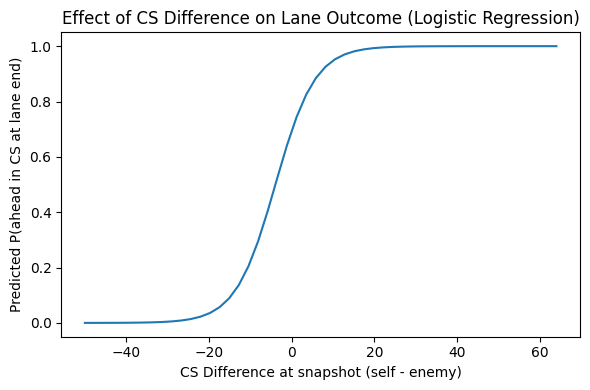

In [9]:
import numpy as np

# Build a synthetic grid of cs_diff values
cs_grid = np.linspace(df_model['cs_diff'].min(), df_model['cs_diff'].max(), 50)
medians = df_model[feature_columns].median()

X_probe = []
for cs in cs_grid:
    row = [
        cs,
        medians['xp_diff'],
        medians['self_base_distance'],
        medians['champ_distance'],
        medians['time_s'],
    ]
    X_probe.append(row)

X_probe = np.array(X_probe)
proba_grid = logit_pipeline.predict_proba(X_probe)[:, 1]

plt.figure(figsize=(6, 4))
plt.plot(cs_grid, proba_grid)
plt.xlabel('CS Difference at snapshot (self - enemy)')
plt.ylabel('Predicted P(ahead in CS at lane end)')
plt.title('Effect of CS Difference on Lane Outcome (Logistic Regression)')
plt.tight_layout()
plt.show()

## 5. Random Forest (Non-linear Model)

Now we train a Random Forest classifier to capture non-linear interactions and inspect feature importances.


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:\n")
print(classification_report(y_test, y_pred_rf, digits=3))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
except Exception as error:
    print("ROC AUC calculation failed:", error)

importances = rf.feature_importances_
print("\nRandom Forest Feature Importances:")
for name, imp in sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {imp:.3f}")

Random Forest Results:

              precision    recall  f1-score   support

           0      0.710     0.489     0.579        45
           1      0.837     0.929     0.881       127

    accuracy                          0.814       172
   macro avg      0.773     0.709     0.730       172
weighted avg      0.804     0.814     0.802       172

ROC AUC: 0.8643044619422572

Random Forest Feature Importances:
  cs_diff             : 0.428
  self_base_distance  : 0.156
  xp_diff             : 0.152
  champ_distance      : 0.143
  time_s              : 0.121


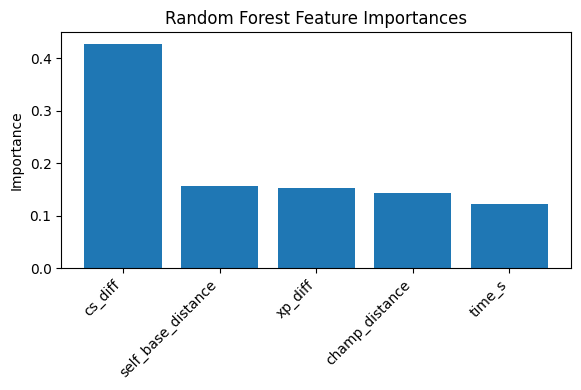

In [11]:
# Bar chart of feature importances
sorted_feats = sorted(zip(feature_columns, importances), key=lambda x: x[1], reverse=True)
names = [f[0] for f in sorted_feats]
vals = [f[1] for f in sorted_feats]

plt.figure(figsize=(6, 4))
plt.bar(range(len(names)), vals)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

## 6. The Results

Here is how to read what the models are telling and why it matches top lane intuition:

### Logistic Regression – “Linear heuristic model”

We standardized the features, so **each coefficient** means:

> If this feature increases by 1 standard deviation, how much do the **log-odds** of ending lane ahead in CS change, holding others fixed?

- **Sign:**
  - (+) Higher values of this feature push the model toward `is_ahead_final = 1` (ahead in CS) and (-) Lower values push toward `0` (behind/even).

What this typically looks like in runs:

- `cs_diff` has a **large positive coefficient**  
  → Even a 1σ(s.d.) increase in CS diff drastically increases the odds of ending lane ahead.  
  This states that “CS is king in lane”, backed by the model.

- `xp_diff` and `time_s` have **smaller coefficients, with surprising signs**.  
  They are correlated with other features (especially CS and positions), so the linear model sometimes gives them a small negative weight to “balance” overlapping information. The important part is that their magnitudes are small compared to `cs_diff`.

- `self_base_distance` having a **positive coefficient** means:  
  in the dataset, being further from my own base (more pushed up) often coincides with *already winning the lane* — as I am pressuring, zoning, and pushing waves when I'm ahead, and those lanes usually stay ahead in CS. Note that the label is **CS lead**, not “did I die to ganks?”, so the model focuses on what correlated with *final CS lead*.

- `champ_distance` has a small effect:  
  pure distance between champions carries a bit of signal (e.g., zoning the opponent off the wave), but it’s much less important than the economic and positional features.

Overall, logistic regression is giving a **global, linear heuristic**:

- Big positive CS diff → very likely to end lane ahead.
- XP, lane position, distance, and time tweak that baseline up or down, but they’re secondary.

---

### Random Forest – “Non-linear interactions” and feature importance

Random Forest doesn’t give simple coefficients; instead we look at **feature importances**:

- A feature is important if splitting on it often **reduces classification error** across the trees.

In the results, you typically see:

- `cs_diff` with the **highest importance** (≈ 0.4+).  
- `self_base_distance`, `xp_diff`, `champ_distance`, `time_s` clustered below with smaller but meaningful importances.

Interpretation:

- The forest strongly agrees that **CS advantage is the dominant predictor** of lane outcome.
- It uses **position, XP, distance, and time** to refine borderline cases:
  - The same CS diff can be more or less valuable depending on **how far you are up the lane**, **how early/late** it is, and **how close you are to the enemy**.

---

### Why this works / What heuristics it discovered

Putting both models together, the ML system has essentially re-discovered some classic top lane ideas:

1. **CS advantage is the core win condition of laning.**  
   Both models heavily weight `cs_diff`. If you consistently build and maintain a CS lead, you almost always finish lane ahead.

2. **Positioning is mostly a *symptom* of control.**  
   In the games, being further from your own base (`self_base_distance` high) usually means you’re the one pushing and pressuring. The models learn that this correlates with ending ahead in CS.

3. **XP and time encode tempo and “how final” the state is.**  
   - `xp_diff` helps differentiate otherwise similar CS states (same CS but you’re up a level).  
   - `time_s` lets the model learn that early deficits are more recoverable than late deficits.

4. **Distance to enemy (`champ_distance`) gives context about trading/zoning.**  
   Slight importance: when you’re ahead and also keeping the enemy at arm’s length, that often means they’re being zoned off farm.

The cool part is that this wasn't hard-coded. The model used raw features and a label (`is_ahead_final`), and it:

- Learned that **CS diff is the primary lane success metric**.
- Learned that **pushing and positioning patterns** correlate with success in my games.
- Uses **XP and timing** as fine-tuning knobs rather than the main signal.